In [1]:
%load_ext autoreload
%autoreload 2

# Needed imports
from abtest import utils # local utils; see utils.py
import pandas as pd
import numpy as np
from statsmodels.stats import proportion as ssp
from scipy import stats

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# Some settings for the notebook
%precision 5
np.set_printoptions(precision=4)
pd.set_option('precision',4)

The focus of this section is on the following case.
The experiment consists of two groups: control and variant.
Each user can either convert or not and the metric of interest is the conversion rate.
Set the null and alternative hypotheses as follows:

$$\begin{align}
H_0:\quad & p_c = p_v \\
H_a:\quad & p_c \neq p_v
\end{align}$$

As before, you can start with a simulation of an experiment.

In [2]:
exp = utils.generate_experiment(seed=43, N=10000, control_cr=0.3, variant_cr=0.3)
exp

,Converted,Visited,CR_pct
Control,3090,10000,30.90
Variant,2952,10000,29.52


The question you will answer in this section is:
> Is the difference witnessed between the proportions "real" or just due to randomness?

This is the time to introduce the *two-sided $Z$-test*

## Two-sided $Z$-test

Recall that $p_c$ is the conversion rate (or proportion) for the control group and $p_v$ is the one for the variant; both are, in reality, known!
Next, $\hat{p}_c$ and $\hat{p}_v$ are the rates witnessed in the experiment.
In the table above they are given as percentages in the column `CR_pct`.

### By hand

Under the hood, for each group you obtain a vector $c = (c_1, c_2, \ldots, c_N)$ and $v = (v_1, v_2, \ldots, v_N)$ where $c_i, v_i \in \{0,1\}$ and $N$ is the number of visitors in the group (here assumed to be the same).
From this, we have that:

$$
\begin{align}
\hat{p}_c = \frac{\sum c_i}{N} \\
\hat{p}_v = \frac{\sum v_i}{N}
\end{align}
$$

In other words, the witnessed proportions are means of the values observed.
Therefore, by the [central limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), both are approximately normally distributed.
Thus also their difference $\hat{p}_c - \hat{p}_v$.
In this case, the following  $z$-statistic is to be used [[ref]](https://onlinecourses.science.psu.edu/stat414/node/268)

$$z = \frac{\hat{p}_c - \hat{p}_v}{\sqrt{\frac{\hat{p}(1-\hat{p})}{c_t} + \frac{\hat{p}(1-\hat{p})}{v_t} }} $$

Where

$$\hat{p} = \frac{c_t \hat{p}_c + v_t \hat{p}_v}{c_t + v_t}$$ 

is the *pooled* proportion where $c_t$ and $v_t$ are the sample sizes of the control and variant groups, respectively.
You can find the above formula implemented in `utils.manual_z_score`; and you can compute the statistic for the data generated for the experiment above.

Note that in this computation the *pooled* version of the variant is used. An un-pooled computation can also be used, but it is less recommended [[ref]](https://stats.stackexchange.com/a/17205/54320).

In [3]:
z_score = utils.manual_z_score(exp)
z_score

2.12516

It is time to better understand what this score means.
The obtained $Z$-score indicates where the results of the experiment lies on the normal distribution:

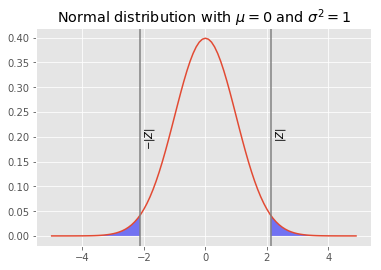

In [4]:
x = np.arange(-5, 5, step=0.1)
z_score = utils.manual_z_score(exp)
x = np.append(x, [-z_score, z_score])
x = np.sort(x)
y = stats.norm.pdf(x)

fig, ax = plt.subplots(1, 1)
ax.plot(x , y)
ax.fill_between(x[x <= -abs(z_score)], 
                y1=y[x <= -abs(z_score)], alpha=0.5, facecolor='blue');
ax.fill_between(x[x >= abs(z_score)], 
                y1=y[x >= abs(z_score)], alpha=0.5, facecolor='blue')
plt.axvline(z_score, color='gray')
plt.axvline(-z_score, color='gray')
plt.text(z_score + 0.1, 0.2, '$|Z|$', rotation=90)
plt.text(-z_score + 0.1, 0.2, '$-|Z|$', rotation=90)
plt.title('Normal distribution with $\mu = 0$ and $\sigma^2 = 1$');

Recall that the question that has to be answered is:
> What is the likelihood to witness even more extreme results than those witnessed in the experiment?

This can be answered by computing the area to the left of $-|Z|$ and to the right of $|Z|$ (shaded in the plot above). 
By symmetry it is enough to compute the area to the left of $-|Z|$ and multiply the result by $2$.
The [cumulative distribution function (cdf)](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of the normal distribution can be used:

In [5]:
2 * stats.norm.cdf(-abs(z_score))

0.03357

Say hello to the mighty $p$-value!
This value tells you how likely is it to witness even more extreme difference given the null hypothesis holds.
Recall, that $H_0$ is that the two proportions are the same.
You can now convince yourself that this is indeed the meaning of the $p$-value.
Do so by running a simulation: run $M$ identical experiments and check in how many of them you witness more extreme results.

In [6]:
M = 1000
N = 10000
base_cr_diff = abs((exp.Converted / exp.Visited).diff()[-1])
np.random.seed(1492)
seeds = np.random.randint(0, 2**32-1, size=(M))
control_cr = 0.3 # 30% 
variant_cr = 0.3 # 30%
experiments = [
    utils.generate_experiment(
        seed=seed, N=N, control_cr=control_cr, variant_cr=variant_cr
    ) for seed in seeds]
cr_diffs = pd.Series([(exp.Converted / exp.Visited).diff()[-1] for exp in experiments])

print(
    "In ~{}% of the simulations the difference between the proportions\n"
    "is at least {:03.3f} (the one in the base experiment)".format(
        np.round(100 * np.sum(np.abs(cr_diffs) > base_cr_diff) / M, decimals=2),
        base_cr_diff
    ))

In ~3.5% of the simulations the difference between the proportions
is at least 0.014 (the one in the base experiment)


#### Summary

You obtained the results of a (simulated) experiment (with random seed $43$) where the underlaying proportions are predefined.
Due to pure randomness you witness a difference between the conversion rates which might be considered big: 
$$
100 \cdot \frac{30.90 - 29.52}{29.52} = 4.675\%
$$

But is it really that big? If you had ran more experiments, what is the likelihood that you would witness an even bigger difference?
The $p$-value as computed above, answers this very question.
It is now a question of interpretation; can you live peacefully knowing that this extremity is to be expected in $\sim 3.38\%$ of the cases?
In all other cases the difference is smaller!
Are you taking a risk by deciding based on this finding?

Later on you will learn how to better evaluate the validity (or *power*) of the test.
You will also learn how to assess the results of such an A/B test using a Bayesian approach.

### The Python way

Now, once you hopefully have deeper understanding of the meaning of the $p$-value, you should know how to easily compute it.
The easiest way is to use [`statsmodels.stats.proportions.proportions_ztest`](http://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html):

In [7]:
# ssp.proportions_ztest returns a tuple contaiing two values
res_ztest = ssp.proportions_ztest(exp.Converted, exp.Visited, alternative='two-sided')
print("z-score = %f" % res_ztest[0])
print("p-value = %f" % res_ztest[1])

z-score = 2.125162
p-value = 0.033573


The values above are exactly the $Z$-score and the $p$-value as we computed by hand above.
At this point it is worthy to mention also the $\chi^2$-test which is implemented in [`scipy.stats.chi2_contingency`](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.chi2_contingency.html).
For this to work, the aggregation of the data should be a little altered:

In [8]:
# In this case the function returns also the number of degrees of freedom and 
# the expected frequencies
res_chi2 = stats.contingency.chi2_contingency(
    pd.concat([exp.Converted, exp.Visited - exp.Converted], axis=1), 
    correction=False) # Keeping the default True would yield different resutls
                      # due to the Yates’ correction
print("z-score = %f" % res_chi2[0])
print("p-value = %f" % res_chi2[1])

z-score = 4.516315
p-value = 0.033573


You should notice that this approach yields the *same* $p$-value but a different score.
The math behind this is beyond the scope of this post.